# ACS2 in Maze
This notebook presents how to integrate ACS2 algorithm with maze environment (using OpenAI Gym interface).

Begin with attaching required dependencies. Because most of the work is by now done locally no PIP modules are used (just pure OS paths)

In [1]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.INFO)

# ALCS + Custom environments
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
#sys.path.append("/Users/khozzy/Projects/openai-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration
from alcs.acs2 import ClassifiersList

# Load environments
import gym
import gym_maze

## Environment - Maze
We are going to look at provided mazes. Their names starts with "_Maze..._" or "_Woods..._" so see what is possible to load:

In [2]:
# Custom function for obtaining available environments
filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods")

all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze4-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze6-v0], non-deterministic: [True], trials: [100]
Maze ID: [Woods1-v0], non-deterministic: [False], trials: [100]
Maze ID: [Woods14-v0], non-deterministic: [False], trials: [100]


Let's see how it looks in action. First we are going to initialize new environment using `gym.make()` instruction from OpenAI Gym.

In [3]:
MAZE = "Woods14-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()

INFO:gym.envs.registration:Making new env: Woods14-v0



■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ □ ■
■ □ ■ ■ ■ □ ■ ■ □ ■ □ ■ A ■
■ □ ■ ■ ■ □ ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ □ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


The `reset()` function puts an agent into random position (on path inside maze) returning current perception.

> The perception consists of 8 values representing N, NE, E, SE, S, SW, W, NW directions. It outputs 0 for the path, 1 for the wall and 9 for the reward.

In [4]:
# Show current agents perception
situation

('0', '1', '1', '1', '1', '0', '1', '1')

We can interact with the environment by performing actions.

> Agent can perform 8 actions - moving into different directions.

To do so use `step(action)` function. It will return couple interesting information:
- new state percepton,
- reward for executing move (ie. finding the reward)
- is the trial finish,
- debug data

In [5]:
ACTION = 0 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

# Render the env one more time after executing step
maze.render()

New state: ('1', '1', '1', '1', '0', '1', '1', '1'), reward: 0, is done: False

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ A ■
■ □ ■ ■ ■ □ ■ ■ □ ■ □ ■ □ ■
■ □ ■ ■ ■ □ ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ □ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


## Agent - ACS2
First provide a helper method for calculating obtained knowledge

In [6]:
def calculate_knowledge(maze, population):
    transitions = maze.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:
        p0 = maze.env.maze.perception(*start)
        p1 = maze.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return {
        'knowledge': nr_correct / len(transitions) * 100.0
    }

### Exploration phase

In [7]:
CLASSIFIER_LENGTH=8
NUMBER_OF_POSSIBLE_ACTIONS=8

# Define agent's default configuration
cfg = ACS2Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    performance_fcn=calculate_knowledge)

# Define agent
agent = ACS2(cfg)

# Exploration phase
maze.reset()
population, metrics = agent.explore(maze, 10)

INFO:root:{'agent': {'population': 15, 'numerosity': 15, 'reliable': 0, 'fitness': 3.2019783494896443, 'trial': 0, 'steps': 37, 'total_steps': 37}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 16, 'numerosity': 16, 'reliable': 0, 'fitness': 5.762241074881416, 'trial': 1, 'steps': 7, 'total_steps': 44}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 33, 'numerosity': 33, 'reliable': 0, 'fitness': 5.44023501322247, 'trial': 2, 'steps': 50, 'total_steps': 94}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 51, 'numerosity': 51, 'reliable': 0, 'fitness': 4.92146815329776, 'trial': 3, 'steps': 50, 'total_steps': 144}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 53, 'numerosity': 53, 'reliable': 0, 'fitness': 5.652597415392324, 'trial': 4, 'steps': 13, 'total_steps': 157}, 'environment': None, 'performance': {'kno

We can take a sneak peek into a created list of classifiers. Let's have a look at top 10:

In [8]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

####9###-4-####1### @ 0x10e19f0f0 	q: 0.65 	r: 185.82 	ir: 185.49
1###01##-4-0###10## @ 0x10fb6bda0 	q: 0.68 	r: 91.42 	ir: 82.18
##0#####-4-######## @ 0x10dc947b8 	q: 0.73 	r: 66.67 	ir: 59.95
###0####-4-######## @ 0x10fb8c940 	q: 0.53 	r: 77.82 	ir: 70.46
#####0##-4-######## @ 0x10fb40fd0 	q: 0.65 	r: 59.73 	ir: 56.95
######0#-4-######## @ 0x10fb8cf60 	q: 0.55 	r: 70.36 	ir: 63.59
####1###-4-######## @ 0x10fb434e0 	q: 0.85 	r: 41.67 	ir: 34.10
##0####0-4-######## @ 0x10fb96ef0 	q: 0.63 	r: 50.47 	ir: 41.87
0##10###-4-###01### @ 0x10dcc2588 	q: 0.59 	r: 51.30 	ir: 42.19
####1##0-4-######## @ 0x10fb96f98 	q: 0.59 	r: 50.47 	ir: 41.87


### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as *apriori* knowledge.

In [9]:
# Reinitialize agent using defined configuration and population
agent = ACS2(cfg, population)

# Reset the environment
maze.reset()
population, metrics = agent.exploit(maze, 1)

INFO:root:{'agent': {'population': 106, 'numerosity': 106, 'reliable': 4, 'fitness': 7.532225633971219, 'trial': 0, 'steps': 2, 'total_steps': 2}, 'environment': None, 'performance': {'knowledge': 2.857142857142857}}


In [10]:
metrics[0:3]

[{'agent': {'fitness': 7.532225633971219,
   'numerosity': 106,
   'population': 106,
   'reliable': 4,
   'steps': 2,
   'total_steps': 2,
   'trial': 0},
  'environment': None,
  'performance': {'knowledge': 2.857142857142857}}]

## Experiments

In [38]:
maze = gym.make('Woods14-v0')

TRIALS_EXPLORE = 1000
TRIALS_EXPLOIT = 100

# explore
agent = ACS2(cfg)
population_explore, metrics_explore = agent.explore(maze, TRIALS_EXPLORE)

# exploit
agent = ACS2(cfg, population_explore)
population_exploit, metrics_exploit = agent.exploit(maze, TRIALS_EXPLOIT)

INFO:gym.envs.registration:Making new env: Woods14-v0
INFO:root:{'agent': {'population': 16, 'numerosity': 16, 'reliable': 0, 'fitness': 0.22885070272781202, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 30, 'numerosity': 30, 'reliable': 0, 'fitness': 0.22380010672980302, 'trial': 1, 'steps': 50, 'total_steps': 100}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 43, 'numerosity': 43, 'reliable': 0, 'fitness': 0.20531331286496338, 'trial': 2, 'steps': 50, 'total_steps': 150}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 51, 'numerosity': 51, 'reliable': 2, 'fitness': 0.20379194291276784, 'trial': 3, 'steps': 50, 'total_steps': 200}, 'environment': None, 'performance': {'knowledge': 5.714285714285714}}
INFO:root:{'agent': {'population': 67, 'numerosity': 67, 'reliable': 1, 'fitness': 0.19859270629129627, 'tria

INFO:root:{'agent': {'population': 121, 'numerosity': 121, 'reliable': 42, 'fitness': 2.126647562985218, 'trial': 37, 'steps': 50, 'total_steps': 1763}, 'environment': None, 'performance': {'knowledge': 51.42857142857142}}
INFO:root:{'agent': {'population': 120, 'numerosity': 120, 'reliable': 43, 'fitness': 2.1413859684070276, 'trial': 38, 'steps': 50, 'total_steps': 1813}, 'environment': None, 'performance': {'knowledge': 54.285714285714285}}
INFO:root:{'agent': {'population': 120, 'numerosity': 120, 'reliable': 47, 'fitness': 2.1334010148697797, 'trial': 39, 'steps': 50, 'total_steps': 1863}, 'environment': None, 'performance': {'knowledge': 54.285714285714285}}
INFO:root:{'agent': {'population': 120, 'numerosity': 120, 'reliable': 47, 'fitness': 2.76598945118984, 'trial': 40, 'steps': 1, 'total_steps': 1864}, 'environment': None, 'performance': {'knowledge': 54.285714285714285}}
INFO:root:{'agent': {'population': 119, 'numerosity': 119, 'reliable': 47, 'fitness': 2.7644191437689574,

INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 69, 'fitness': 8.425571576214056, 'trial': 74, 'steps': 50, 'total_steps': 3136}, 'environment': None, 'performance': {'knowledge': 77.14285714285715}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 69, 'fitness': 8.418316169717274, 'trial': 75, 'steps': 50, 'total_steps': 3186}, 'environment': None, 'performance': {'knowledge': 77.14285714285715}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 70, 'fitness': 8.414903700617753, 'trial': 76, 'steps': 50, 'total_steps': 3236}, 'environment': None, 'performance': {'knowledge': 77.14285714285715}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 70, 'fitness': 8.412798001504443, 'trial': 77, 'steps': 50, 'total_steps': 3286}, 'environment': None, 'performance': {'knowledge': 77.14285714285715}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 71, 'fitness': 8.401919958588074, 'tr

INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 82, 'fitness': 14.581088788944648, 'trial': 111, 'steps': 50, 'total_steps': 4614}, 'environment': None, 'performance': {'knowledge': 85.71428571428571}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 82, 'fitness': 16.185037243164462, 'trial': 112, 'steps': 5, 'total_steps': 4619}, 'environment': None, 'performance': {'knowledge': 85.71428571428571}}
INFO:root:{'agent': {'population': 108, 'numerosity': 108, 'reliable': 82, 'fitness': 16.01153068786938, 'trial': 113, 'steps': 50, 'total_steps': 4669}, 'environment': None, 'performance': {'knowledge': 85.71428571428571}}
INFO:root:{'agent': {'population': 112, 'numerosity': 112, 'reliable': 83, 'fitness': 16.292890493361902, 'trial': 114, 'steps': 40, 'total_steps': 4709}, 'environment': None, 'performance': {'knowledge': 88.57142857142857}}
INFO:root:{'agent': {'population': 112, 'numerosity': 112, 'reliable': 83, 'fitness': 16.9877631057212

INFO:root:{'agent': {'population': 112, 'numerosity': 112, 'reliable': 87, 'fitness': 41.734605610286636, 'trial': 148, 'steps': 3, 'total_steps': 5822}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 112, 'numerosity': 112, 'reliable': 87, 'fitness': 41.03895482812113, 'trial': 149, 'steps': 50, 'total_steps': 5872}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 111, 'numerosity': 111, 'reliable': 87, 'fitness': 41.613970352206245, 'trial': 150, 'steps': 50, 'total_steps': 5922}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 111, 'numerosity': 111, 'reliable': 87, 'fitness': 43.819479373508386, 'trial': 151, 'steps': 46, 'total_steps': 5968}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 110, 'numerosity': 110, 'reliable': 88, 'fitness': 45.1366948295506

INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 91, 'fitness': 71.07299859190358, 'trial': 185, 'steps': 50, 'total_steps': 7103}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 91, 'fitness': 70.42869100137415, 'trial': 186, 'steps': 50, 'total_steps': 7153}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 91, 'fitness': 69.87045312675464, 'trial': 187, 'steps': 50, 'total_steps': 7203}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 91, 'fitness': 69.25102948430468, 'trial': 188, 'steps': 50, 'total_steps': 7253}, 'environment': None, 'performance': {'knowledge': 94.28571428571428}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 91, 'fitness': 75.07200031455066,

INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 94, 'fitness': 99.51407433495899, 'trial': 222, 'steps': 44, 'total_steps': 8254}, 'environment': None, 'performance': {'knowledge': 97.14285714285714}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 94, 'fitness': 106.7833279839313, 'trial': 223, 'steps': 25, 'total_steps': 8279}, 'environment': None, 'performance': {'knowledge': 97.14285714285714}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 94, 'fitness': 109.78829285775234, 'trial': 224, 'steps': 20, 'total_steps': 8299}, 'environment': None, 'performance': {'knowledge': 97.14285714285714}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 94, 'fitness': 109.12081755640041, 'trial': 225, 'steps': 50, 'total_steps': 8349}, 'environment': None, 'performance': {'knowledge': 97.14285714285714}}
INFO:root:{'agent': {'population': 103, 'numerosity': 103, 'reliable': 94, 'fitness': 113.539559248305

INFO:root:{'agent': {'population': 102, 'numerosity': 102, 'reliable': 95, 'fitness': 161.95381855599692, 'trial': 260, 'steps': 19, 'total_steps': 9267}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 102, 'numerosity': 102, 'reliable': 95, 'fitness': 159.22960924332648, 'trial': 261, 'steps': 50, 'total_steps': 9317}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 102, 'numerosity': 102, 'reliable': 95, 'fitness': 156.64291332723897, 'trial': 262, 'steps': 50, 'total_steps': 9367}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 102, 'numerosity': 102, 'reliable': 95, 'fitness': 160.77048379147723, 'trial': 263, 'steps': 13, 'total_steps': 9380}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 102, 'numerosity': 102, 'reliable': 95, 'fitness': 162.81035724723708, 'trial': 264, 'steps': 18, 'total_steps': 

INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 96, 'fitness': 218.646761191872, 'trial': 299, 'steps': 21, 'total_steps': 10445}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 96, 'fitness': 214.2643145950802, 'trial': 300, 'steps': 50, 'total_steps': 10495}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 96, 'fitness': 217.06296310063263, 'trial': 301, 'steps': 21, 'total_steps': 10516}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 96, 'fitness': 218.4540434219929, 'trial': 302, 'steps': 25, 'total_steps': 10541}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 96, 'fitness': 214.70634219467283, 'trial': 303, 'steps': 50, 'total_steps': 

INFO:root:{'agent': {'population': 99, 'numerosity': 99, 'reliable': 96, 'fitness': 235.397614155535, 'trial': 338, 'steps': 50, 'total_steps': 11423}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 99, 'numerosity': 99, 'reliable': 96, 'fitness': 235.40011734393485, 'trial': 339, 'steps': 2, 'total_steps': 11425}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 99, 'numerosity': 99, 'reliable': 96, 'fitness': 240.99259449138063, 'trial': 340, 'steps': 36, 'total_steps': 11461}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 99, 'numerosity': 99, 'reliable': 96, 'fitness': 242.97314087138733, 'trial': 341, 'steps': 18, 'total_steps': 11479}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 99, 'numerosity': 99, 'reliable': 97, 'fitness': 244.2018190389569, 'trial': 342, 'steps': 4, 'total_steps': 11483}, 'en

INFO:root:{'agent': {'population': 98, 'numerosity': 98, 'reliable': 97, 'fitness': 280.2905999924031, 'trial': 377, 'steps': 50, 'total_steps': 12303}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 98, 'numerosity': 98, 'reliable': 97, 'fitness': 281.7913561122831, 'trial': 378, 'steps': 8, 'total_steps': 12311}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 98, 'numerosity': 98, 'reliable': 97, 'fitness': 282.28336567633784, 'trial': 379, 'steps': 7, 'total_steps': 12318}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 98, 'numerosity': 98, 'reliable': 97, 'fitness': 283.1602173511667, 'trial': 380, 'steps': 9, 'total_steps': 12327}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 98, 'numerosity': 98, 'reliable': 97, 'fitness': 279.9337400803752, 'trial': 381, 'steps': 50, 'total_steps': 12377}, 'envi

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 315.4342842304614, 'trial': 416, 'steps': 20, 'total_steps': 13355}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 315.71167746068306, 'trial': 417, 'steps': 6, 'total_steps': 13361}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 312.89861855422004, 'trial': 418, 'steps': 50, 'total_steps': 13411}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 314.07741485907906, 'trial': 419, 'steps': 40, 'total_steps': 13451}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 317.7617180519772, 'trial': 420, 'steps': 13, 'total_steps': 13464}, '

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 385.33482250722136, 'trial': 455, 'steps': 23, 'total_steps': 14279}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 386.33570464437605, 'trial': 456, 'steps': 9, 'total_steps': 14288}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 386.6605020108903, 'trial': 457, 'steps': 6, 'total_steps': 14294}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 388.5970133985707, 'trial': 458, 'steps': 12, 'total_steps': 14306}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 388.59702655991566, 'trial': 459, 'steps': 2, 'total_steps': 14308}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 431.1268278622402, 'trial': 494, 'steps': 21, 'total_steps': 15145}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 431.12959030354386, 'trial': 495, 'steps': 5, 'total_steps': 15150}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 433.4354260468137, 'trial': 496, 'steps': 20, 'total_steps': 15170}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 435.0395235098133, 'trial': 497, 'steps': 17, 'total_steps': 15187}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 435.85385202822357, 'trial': 498, 'steps': 7, 'total_steps': 15194}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 460.43015251304087, 'trial': 533, 'steps': 30, 'total_steps': 15933}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 460.771269580983, 'trial': 534, 'steps': 6, 'total_steps': 15939}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 462.70905288445545, 'trial': 535, 'steps': 30, 'total_steps': 15969}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 464.85471432917274, 'trial': 536, 'steps': 35, 'total_steps': 16004}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 466.0834163194568, 'trial': 537, 'steps': 36, 'total_steps': 16040}, 'e

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 499.9597927125653, 'trial': 572, 'steps': 50, 'total_steps': 16824}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 499.9597927231323, 'trial': 573, 'steps': 1, 'total_steps': 16825}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 499.8082923382904, 'trial': 574, 'steps': 28, 'total_steps': 16853}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 499.9885739849105, 'trial': 575, 'steps': 41, 'total_steps': 16894}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 496.1509700412554, 'trial': 576, 'steps': 26, 'total_steps': 16920}, 'env

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 520.1747672680417, 'trial': 611, 'steps': 18, 'total_steps': 17775}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 520.7665843543541, 'trial': 612, 'steps': 6, 'total_steps': 17781}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 522.4203023763566, 'trial': 613, 'steps': 38, 'total_steps': 17819}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 523.1969824472746, 'trial': 614, 'steps': 16, 'total_steps': 17835}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 523.4222492917487, 'trial': 615, 'steps': 4, 'total_steps': 17839}, 'envi

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 533.2815915371518, 'trial': 650, 'steps': 24, 'total_steps': 18619}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 535.6903107577033, 'trial': 651, 'steps': 24, 'total_steps': 18643}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 536.6365121609284, 'trial': 652, 'steps': 20, 'total_steps': 18663}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 535.2295149142058, 'trial': 653, 'steps': 34, 'total_steps': 18697}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 537.2614448327387, 'trial': 654, 'steps': 24, 'total_steps': 18721}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 565.208560514265, 'trial': 689, 'steps': 15, 'total_steps': 19633}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 560.6587778379662, 'trial': 690, 'steps': 44, 'total_steps': 19677}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 561.3132489527928, 'trial': 691, 'steps': 25, 'total_steps': 19702}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 563.9004306074153, 'trial': 692, 'steps': 30, 'total_steps': 19732}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 564.0929013819456, 'trial': 693, 'steps': 12, 'total_steps': 19744}, 'env

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 577.9968175866213, 'trial': 728, 'steps': 24, 'total_steps': 20696}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 578.4235608082142, 'trial': 729, 'steps': 21, 'total_steps': 20717}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 578.8701668586863, 'trial': 730, 'steps': 30, 'total_steps': 20747}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 579.1282838829322, 'trial': 731, 'steps': 24, 'total_steps': 20771}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 580.1842221756232, 'trial': 732, 'steps': 11, 'total_steps': 20782}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 588.1304514748175, 'trial': 767, 'steps': 9, 'total_steps': 21555}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 588.8812952455523, 'trial': 768, 'steps': 27, 'total_steps': 21582}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 588.881295245553, 'trial': 769, 'steps': 1, 'total_steps': 21583}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 589.5307102784095, 'trial': 770, 'steps': 22, 'total_steps': 21605}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 587.4788625016988, 'trial': 771, 'steps': 50, 'total_steps': 21655}, 'envir

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 594.8654267192451, 'trial': 806, 'steps': 47, 'total_steps': 22452}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 596.6523828761582, 'trial': 807, 'steps': 33, 'total_steps': 22485}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 597.4305259319533, 'trial': 808, 'steps': 23, 'total_steps': 22508}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 597.8172712399884, 'trial': 809, 'steps': 8, 'total_steps': 22516}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 598.4448265915361, 'trial': 810, 'steps': 16, 'total_steps': 22532}, 'env

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 608.1687995870725, 'trial': 845, 'steps': 50, 'total_steps': 23357}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 609.1923836447515, 'trial': 846, 'steps': 42, 'total_steps': 23399}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 609.34401931025, 'trial': 847, 'steps': 13, 'total_steps': 23412}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 609.8787523654289, 'trial': 848, 'steps': 14, 'total_steps': 23426}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 610.2866902103348, 'trial': 849, 'steps': 5, 'total_steps': 23431}, 'envir

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 610.0855313052544, 'trial': 884, 'steps': 1, 'total_steps': 24237}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 610.9782138837061, 'trial': 885, 'steps': 29, 'total_steps': 24266}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 611.1461278392529, 'trial': 886, 'steps': 18, 'total_steps': 24284}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 611.2660106784623, 'trial': 887, 'steps': 20, 'total_steps': 24304}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 612.3389550434406, 'trial': 888, 'steps': 43, 'total_steps': 24347}, 'env

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 612.3477118943167, 'trial': 923, 'steps': 30, 'total_steps': 25259}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 612.3642877548714, 'trial': 924, 'steps': 47, 'total_steps': 25306}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 609.9518373315178, 'trial': 925, 'steps': 50, 'total_steps': 25356}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 611.6591801098034, 'trial': 926, 'steps': 22, 'total_steps': 25378}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 610.5610390791625, 'trial': 927, 'steps': 40, 'total_steps': 25418}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 619.7975534401007, 'trial': 962, 'steps': 15, 'total_steps': 26303}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 619.5214526095252, 'trial': 963, 'steps': 38, 'total_steps': 26341}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 619.7466800218305, 'trial': 964, 'steps': 40, 'total_steps': 26381}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 620.3784789664063, 'trial': 965, 'steps': 29, 'total_steps': 26410}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 619.2364213994216, 'trial': 966, 'steps': 50, 'total_steps': 26460}, 'en

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 627.3389987473073, 'trial': 1, 'steps': 2, 'total_steps': 7}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 627.3548760384895, 'trial': 2, 'steps': 14, 'total_steps': 21}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 627.3726144295917, 'trial': 3, 'steps': 4, 'total_steps': 25}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 627.393687914538, 'trial': 4, 'steps': 9, 'total_steps': 34}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 627.3950728001785, 'trial': 5, 'steps': 2, 'total_steps': 36}, 'environment': None, 'performance'

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.2181838856471, 'trial': 41, 'steps': 4, 'total_steps': 355}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.2257454721685, 'trial': 42, 'steps': 4, 'total_steps': 359}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.2257454721685, 'trial': 43, 'steps': 1, 'total_steps': 360}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.2418250036592, 'trial': 44, 'steps': 15, 'total_steps': 375}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.2769926118677, 'trial': 45, 'steps': 17, 'total_steps': 392}, 'environment': None, 

INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.930732173177, 'trial': 81, 'steps': 4, 'total_steps': 729}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.930763287525, 'trial': 82, 'steps': 2, 'total_steps': 731}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 628.9612192220329, 'trial': 83, 'steps': 17, 'total_steps': 748}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 629.0400874319309, 'trial': 84, 'steps': 18, 'total_steps': 766}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 97, 'numerosity': 97, 'reliable': 97, 'fitness': 629.0458936883988, 'trial': 85, 'steps': 6, 'total_steps': 772}, 'environment': None, 'p

In [39]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['steps'] = row['agent']['steps']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['knowledge'] = row['performance']['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [40]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)

# show 5 random metrics
metrics_df.sample(5).sort_index()

,phase,steps,numerosity,reliable,knowledge
trial,,,,,
176,explore,50,105,90,94.285714
812,explore,1,97,97,100.000000
842,explore,35,97,97,100.000000
882,explore,21,97,97,100.000000
1078,exploit,4,97,97,100.000000


For various mazes visualize
- classifiers / reliable classifiers for steps
- optimal policy
- steps (exploration | exploitation)
- knowledge
- parameters setting

In [41]:
def find_best_classifier(population, situation, cfg):
    match_set = ClassifiersList.form_match_set(population, situation, cfg)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population, cfg):
    original = maze.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population, cfg):
    ACTION_LOOKUP = { 
        0: '↑', 1: '↗', 2: '→', 3: '↘',
        4: '↓', 5: '↙', 6: '←', 7: '↖'
    }
    
    original = maze.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action

print(build_action_matrix(maze, population_exploit, cfg))

[['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#'
  '\\#' '\\#']
 ['\\#' '\\#' '↙' '←' '←' '\\#' '\\#' '\\#' '\\#' '↙' '\\#' '\\#' '↓'
  '\\#']
 ['\\#' '↓' '\\#' '\\#' '\\#' '↖' '\\#' '\\#' '↙' '\\#' '↖' '\\#' '↙'
  '\\#']
 ['\\#' '↓' '\\#' '\\#' '\\#' '↑' '\\#' '↘' '\\#' '\\#' '\\#' '↖' '\\#'
  '\\#']
 ['\\#' 'R' '\\#' '\\#' '\\#' '↑' '\\#' '\\#' '↙' '\\#' '\\#' '\\#' '\\#'
  '\\#']
 ['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '↖' '←' '\\#' '\\#' '\\#' '\\#'
  '\\#' '\\#']
 ['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#'
  '\\#' '\\#']]


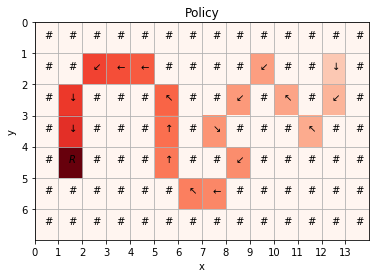

In [42]:
def plot_policy(env, agent, cfg, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = maze.env.maze.max_x
    max_y = maze.env.maze.max_y
    
    fitness_matrix = build_fitness_matrix(maze, agent.population, cfg)
    action_matrix = build_action_matrix(maze, agent.population, cfg)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

plot_policy(maze, agent, cfg)
plt.savefig('maze_policy.eps', format='eps', dpi=100)

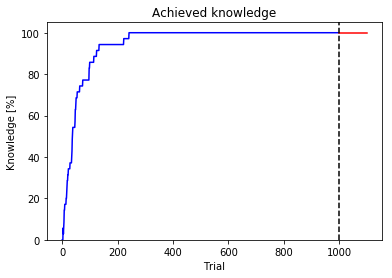

In [43]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Knowledge [%]")
    ax.set_ylim([0, 105])

plot_knowledge(metrics_df)
plt.savefig('maze_knowledge.eps', format='eps', dpi=100)

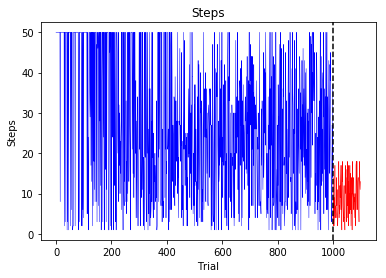

In [44]:
def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Steps")
    
plot_steps(metrics_df)
plt.savefig('maze_steps.eps', format='eps', dpi=100)

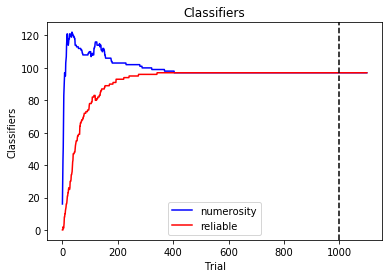

In [45]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Classifiers")
    ax.legend()

plot_classifiers(metrics_df)
plt.savefig('maze_classifiers.eps', format='eps', dpi=100)

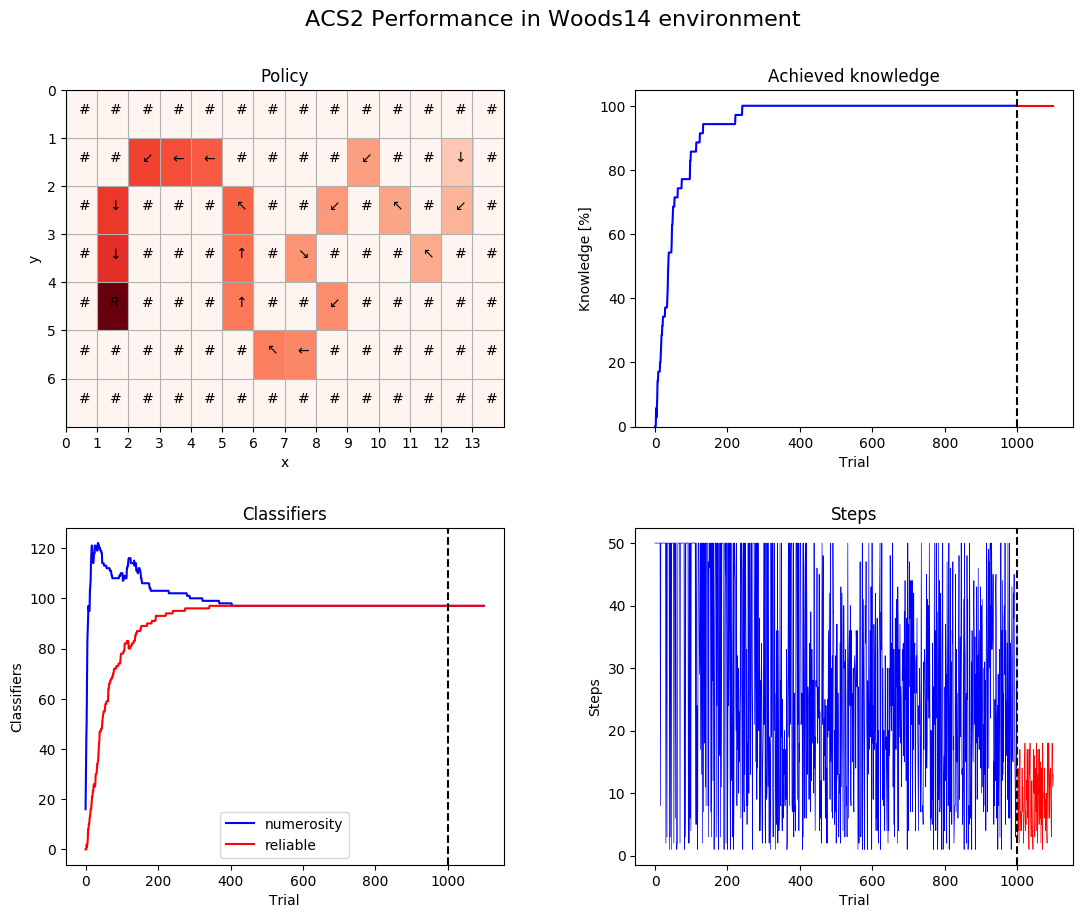

In [47]:
def plot_performance(agent, maze, metrics_df):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('ACS2 Performance in Woods14 environment', fontsize=16)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.3)
    plt.savefig('woods14_ev.eps', format='eps', dpi=100)
    plt.show()

plot_performance(agent, maze, metrics_df)